In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json 
import gmaps
import os
import googlemaps

In [3]:
def graphSelectionRates(selected, candidates, protectedClass):
    selected_candidates = selected.copy()
    candidates_all = candidates.copy()
    raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }
    sexIndxs = {"Male":0, "Female":1}
    
    if protectedClass == "race":
        features = [col for col in selected_candidates if col.startswith("race_")]
        race_selected = selected_candidates[features].idxmax(axis=1).str.replace('race_', '')
        race_all = candidates_all[features].idxmax(axis=1).str.replace('race_', '')
        
        candidates_all["Race"] = race_all
        selected_candidates["Race"] = race_selected

        numCandidates = candidates_all["Race"].value_counts()
        numQualified = selected_candidates["Race"].value_counts()

        selectionRate1 = numQualified["Caucasian"] / numCandidates["Caucasian"]
        selectionRate2 = numQualified["Asian"] / numCandidates["Asian"]
        selectionRate3 = numQualified["African-American"] / numCandidates["African-American"]
        selectionRate4 = numQualified["Hispanic"] / numCandidates["Hispanic"]
        
        print("The selection rate for " + "Caucasian" + "s: ",selectionRate1)
        print("The selection rate for " + "Asian" + "s: ", selectionRate2)
        print("The selection rate for " + "African-American" + "s: ",selectionRate3)
        print("The selection rate for " + "Hispanic" + "s: ",selectionRate4)
        
        y_pos = np.arange(4)
        performance = [selectionRate1, selectionRate2, selectionRate3, selectionRate4]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Caucasian", "Asian", "African-American", "Hispanic"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Race')
        plt.show()
    elif protectedClass == "gender":
        
        features = [col for col in selected_candidates if col.startswith("gender_")]
        gender_selected = selected_candidates[features].idxmax(axis=1).str.replace('gender_', '')
        gender_all = candidates_all[features].idxmax(axis=1).str.replace('gender_', '')

        candidates_all["Gender"] = gender_all
        selected_candidates["Gender"] = gender_selected
        
        numCandidates = candidates_all["Gender"].value_counts()
        numQualified = selected_candidates["Gender"].value_counts()
        
        print(numCandidates)
        print(numQualified) 
        
        maleSelectionRate = numQualified["male"] / numCandidates["male"]
        femaleSelectionRate = numQualified["female"] / numCandidates["female"]
        print("The selection rate for " + "Male" + "s: ", maleSelectionRate)
        print("The selection rate for " + "Female" + "s: ", femaleSelectionRate)
        y_pos = np.arange(2)
        performance = [maleSelectionRate, femaleSelectionRate]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Male", "Female"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Sex')
        plt.show()
    else:
        print("Try another protected type - gender or race")
        
def getOnehottedDataset(dataset, features, prefixes):
# race, sex, sports, birth origin, education, educational prestige, criminal record, arrest record,
    onehotted_data = dataset.copy()
    onehotted_data = pd.get_dummies(onehotted_data, columns=features, prefix=prefixes)
    return onehotted_data

def transformDatapointsToScale(candidates, selectedFeatures):
    df = candidates.copy()
    for feature in selectedFeatures:
        maximum = df[feature].max()
        df[feature] = df[feature].apply(lambda x: x / maximum)
    return df
    
def scoreJobCandidates(candidates, selectedFeatures, weights):
    candidates = candidates.copy()
    for elem in selectedFeatures:
        candidates[elem] = candidates[elem].apply(lambda x: weights[elem] * x)
    candidates["Scores"] = 0
    for elem in selectedFeatures:
        candidates["Scores"] = candidates["Scores"] + candidates[elem]
        
    return candidates
        
def rankJobCandidates(candidates):
    df = candidates.copy()
    df = df.sort_values(["Scores"], ascending=False)
    return df

def selectCandidates(candidates, percentile):
    numCandidates = math.floor(len(candidates) * percentile)
    return candidates.iloc[:numCandidates]

# Milestone 1
## Exercise 2

Alright in the last exercise you and your team wrestled with how to actually label employees.  Now, we'll see how these sort of ranking or labelling decisions are utilized in actual algorithms to perform all kinds of tasks.


To do this, we're going to guide you through the implementation of an extremely naive version of a hiring algorithm based on features in the dataset.  We'll call it the naive ranking model.

Once you design the core components of this ranking model, you'll have the opportunity to run it on a dataset of job candidates (not employees), that Sprawlmart has received applications from for its premier Sales Associate Position.

To introduce you to this ranking model here's how it functions

* Step 1 - Based on your insight into certain features' relation to the employees' performance in the dataset, select features to rank job candidates by.
* Step 2 - Determine weights for each of those features, based on your understanding of their predictive power for the employee's performance that was seen in the small sample of employees.
* Step 3 - Take the sum of those values ==> that's our score
* Step 4 - Rank the candidates based on their score
* Step 5 - Impose a percentile cutoff - everyone above the cutoff makes it past the algorithmic evaluation round! 
  
Your team's job is decide on Step 1 and Step 2 and Step 5, justifying your decision and potential worries. We've already written code for steps 3 and 4!

In [8]:
# We load the sample employees and enable you to view all the features you are
# allowed to use in your model
employees = pd.read_csv("25employees.csv")
bayArea = pd.read_csv("bayArea.csv")
candidates = pd.read_csv("../Candidates_M1/candidates_milestone1.csv")
# Feel free to uncomment these to witness the features
print(employees.info())
print(candidates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Names                         25 non-null     object 
 1   Race                          25 non-null     object 
 2   Gender                        25 non-null     object 
 3   Birth Origin                  25 non-null     object 
 4   Age                           25 non-null     int64  
 5   Education                     25 non-null     float64
 6   GPA                           25 non-null     float64
 7   Educational Prestige          25 non-null     float64
 8   Years of Experience           25 non-null     float64
 9   Soft Skills                   25 non-null     float64
 10  Manager's Assessment Score    25 non-null     float64
 11  Military Tenure               25 non-null     int64  
 12  Zip Codes                     25 non-null     int64  
 13  Job Ten



### Task 0: Data Transformation:
- Oftentimes data is messy or not obviously useful but we might be able to somehow transform or translate it in such a way that it is useful. Take for example these zipcodes, it's not immediately clear what a 5-digit numeric can do for us in trying to build a hiring algorithm. Let's first take a look at where ppl are living...

In [6]:
def getMarkers(dataset, bayArea):
    zipCodes = dataset["Zip Codes"]
    marker_locations = [
       (37.3861, -122.0839) # Our company is located in Mountain View!
    ]

    for x in range(len(zipCodes)):
        row = bayArea.loc[(bayArea["ZIP"] == zipCodes[x])]
        lat = float(row["Latitude"])
        long = float(row["Longitude"])
        marker_locations.append((lat, long))
    return marker_locations

marker_locations = getMarkers(employees, bayArea)
gmaps_apiKey = # INSERT API GMAPS KEY #
gmaps.configure(api_key=gmaps_apiKey)
# gmaps.configure(api_key=os.environ["GMAPS_API_KEY"])
with open('bayarea_zipcodes.geojson') as f:
    geometry = json.load(f)

figure_layout = {
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px'
}

fig = gmaps.figure(layout=figure_layout)
geojson_layer = gmaps.geojson_layer(geometry)
fig.add_layer(geojson_layer)
markers = gmaps.marker_layer(marker_locations)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px'))

It turns out that Google has built a nice API for us to calculate the average commute time between zips. So turns out we can actually use our company's location in Mountain View and calculate how long it takes/took our 25 employees to get to work!

Put in your api key, run the cell below, and check the end of the dataframe to see the commute times!

In [7]:
# RUN THIS CELL (1 Line) #
distancematrix_key = # INSERT YOUR API GOOGLE MAPS KEY #
gmaps = googlemaps.Client(key=distancematrix_key)

company_zipCode = 94039 # Mountain View #
employee_zipCodes = employees["Zip Codes"]

durations = []
for x in range(len(employees)):
    distanceInfo = gmaps.distance_matrix(str(company_zipCode), str(employee_zipCodes[x]))['rows'][0]
    duration = distanceInfo['elements'][0]['duration']['value'] / 60
    durations.append(duration)
    
employees["Avg Commute Time"] = durations
employees.to_csv("25employees.csv", index=False)
employees
# RUN THIS CELL (1 Line) #

,Names,Race,Gender,Birth Origin,Age,Education,GPA,Educational Prestige,Years of Experience,Soft Skills,...,Technical Aptitude,Avg Deals Closed,Undergraduate Degree,LinkedIn Score,Responsible Social Media Use,Employee Referral,HireVue Score,Arrest Record,Criminal Record,Avg Commute Time
0,Willie Moorefield,Caucasian,male,Australia,32,0.458,3.910,0.48,6.3,4.56,...,2.22,7.93,Quantitative,Very Good,Good,1,0.86,0,0,4.483333
1,Nathan Anderson,Asian,male,United States,24,1.845,3.799,0.45,7.9,3.19,...,3.59,8.11,Quantitative,None,Good,1,0.55,0,0,5.233333
2,Gregory Pittman,Caucasian,male,Canada,31,0.935,3.976,0.67,5.1,3.59,...,1.62,4.97,Quantitative,Very Good,Good,1,-1.25,0,0,9.783333
3,Young Berg,African-American,male,United States,32,0.127,4.195,0.40,3.9,4.33,...,1.40,7.05,Engineering,Very Good,Good,1,0.07,0,0,51.833333
4,John Dancy,Caucasian,male,Canada,24,0.466,3.327,0.69,7.7,4.45,...,0.50,11.56,Engineering,Very Good,Good,0,4.50,0,0,51.216667
5,Bruce Potter,Caucasian,female,Canada,32,0.324,2.750,0.55,4.0,3.37,...,-0.23,4.62,Quantitative,Very Good,Good,0,-2.44,0,0,55.366667
6,Byron Farmer,Caucasian,male,United States,25,0.089,3.381,0.81,8.0,3.79,...,-0.10,2.88,Humanities,Ok,Good,0,-3.94,0,0,49.633333
7,Allen Porter,Caucasian,male,Canada,26,0.105,3.049,0.71,5.5,2.98,...,0.64,8.68,Humanities,Ok,Good,0,1.98,0,0,54.866667
8,Jordan Mcsweeney,Caucasian,male,Canada,25,0.291,3.127,0.55,3.3,2.29,...,-0.20,7.77,Engineering,None,Bad,0,0.05,0,0,63.066667
9,Kenneth Sanchez,Other,female,Australia,22,-0.155,2.688,0.17,8.3,3.30,...,-0.49,8.41,Engineering,None,Good,0,-0.14,0,0,40.483333


Great, time to start designing the naive ranking model!

### Task 1: Feature Selection

So an integral part of building our first model for hiring is choosing the most relevant features to include in our assessment of candidates. Notably, there are some challenges with fairness and bias when it comes to feature selection and we want to try and expose some of these issues in the following subtasks. After that, your team will be expected to pick actual features to use in your dataset.


#### Subtask 1:  Features that are Per Se illegal 
* You can use the following code block to examine the distribution of values for a specific categorical feature for a specific protected class. 


##### Question: We know that some features are generally considered per se illegal? Why? Do you see any of these in the dataset? If so, are the general worries with including these features, indeed evident in the dataset?


In [9]:
# We can use the following to see which features may have biased distributions
# Among the dataset.
def displayDistributionOfFeature(dataset, feature, protectedAttribute):
    validAttributes = ["Race", "Sex", "Age", "Birth Origin"]
    if protectedAttribute not in validAttributes:
        print("Protected Attribute not valid")
        return
    print(dataset.groupby([feature, protectedAttribute]).size())
    
feature = "Arrest Record" # INSERT A FEATURE - GPA, Cultural Fit, etc. #
protectedAttribute = "Race" # INSERT A protected class - race, gender, etc. #

print("This is the distribution of values for the 25 employees for the feature:", feature)
displayDistributionOfFeature(employees, feature, protectedAttribute)
print("This is the distribution of values for the job candidates for the feature:", feature)
displayDistributionOfFeature(candidates, feature, protectedAttribute)

This is the distribution of values for the 25 employees for the feature: Arrest Record
Arrest Record  Race            
0              Asian                3
               Caucasian           12
               Hispanic             2
               Other                1
1              African-American     3
               Caucasian            3
               Hispanic             1
dtype: int64
This is the distribution of values for the job candidates for the feature: Arrest Record
Arrest Record  Race            
0.0            African-American     57
               Asian                72
               Caucasian           262
               Hispanic             40
               Other                30
1.0            African-American     13
               Asian                 3
               Caucasian            13
               Hispanic             10
dtype: int64




#### Subtask 2: Differential Validity

* While we don't have an actual model yet to test "performance" on different subgroups, we can form an intuition for what features may or may not contribute to a differential validity problem by examining whether particular feature values correlate with our metrics of performance in distinct ways.

* Note that there are 3 "objective" measures of performance for our employees, the Manager's Assessment Score, Job Tenure, and Avg Deals Closed per Month.

##### Question: Differential validity is the notion that there may exist a test or feature that is very effective or powerful for prediction/classification for one subgroup but is not useful or even harmful for other/s. Try and identify one such feature that if used may lead to a problem of differential validity in our algorithm. Report your findings!

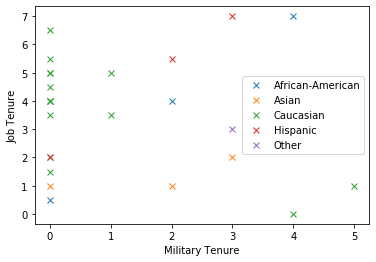

In [24]:
def plotFeatureToPerformance(dataset, feature, metric, protectedClass, val=None):
    df = dataset.copy()
    if val != None:
        if len(val) == 1:
            df = df.loc[(df[protectedClass] == val[0])]
        elif len(val) == 2:
            df = df.loc[(df[protectedClass]== val[0]) | (df[protectedClass]== val[1])]
    df = df[[feature, metric, protectedClass]]
    groups = df.groupby(protectedClass)
    for name, group in groups:
        plt.plot(group[feature], group[metric], marker="x", linestyle="", label=name)
        
    plt.xlabel(feature)
    plt.ylabel(metric)
    plt.legend()
    
feature = "Military Tenure"# INSERT A FEATURE #
metric = "Job Tenure"# SELECT A METRIC #
protectedClass =  "Race"# INSERT A PROTECTED CLASS # 
plotFeatureToPerformance(employees, feature, metric, protectedClass)
# plotFeatureToPerformance(candidates, feature, metric, protectedClass) 

#### Subtask 3: Dealing with powerful predictors that are biased nonetheless

Finally, sometimes there are features that may be quite helpful and powerful predictors for a particular metric but are nonetheless biased. A high score or value on those features might be very predictive of one of the metrics we care about but seems to consistently rank certain groups over others.

##### Question: Try and find if a/some feature/s in the set of employees that do track some performance measure quite well but whose value distribution is not balanced between different groups. Report your findings

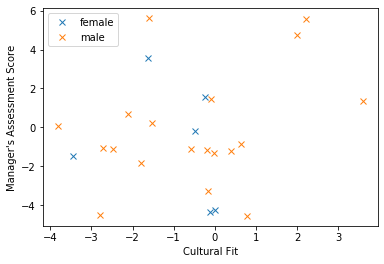

In [13]:
feature = "Cultural Fit"# INSERT A FEATURE #
metric = "Manager's Assessment Score" # SELECT A METRIC #
protectedClass = "Gender"# INSERT A PROTECTED CLASS # 
plotFeatureToPerformance(employees, feature, metric, protectedClass)

#### Subtask 4: Ok now its time to select the features your team wants to use!
##### An aside on one-hotting...
In data science and machine learning practice it is generally good practice to one-hot categorical data. What we mean by that is for a datapoint of a sample whose value represents a particular category it belongs to, we make a new datapoint per category. 

So for example currently, race is categorical. But instead of just having one feature to represent a candidate's race we transform each sample to have one feature per potential race. So race = "African-American", becomes race_African-American = 1, race_Asian = 0, race_Caucasian = 0, and so on.

In [14]:
# Run this Cell (0 Lines) #
# One-hottng the dataset for use
features = ["Race", "Gender", "Birth Origin", "Criminal Record",
           "Arrest Record", "LinkedIn Score", "Responsible Social Media Use", 
            "Sports", "Undergraduate Degree"]
prefixes = ["race", "gender", "origin", "criminal", "arrest", "linkedin", 
           "socmedia", "sports", "degree"]

employees_race = employees["Race"]
candidates_race = candidates["Race"]
sampleEmployees_processed = getOnehottedDataset(employees, features, prefixes)
sampleEmployees_processed["Race"] = employees_race
candidates_processed = getOnehottedDataset(candidates, features, prefixes)
candidates_processed["Race"] = candidates_race

candidates_processed.columns
# Run this Cell #

Index(['Names', 'Age', 'Zip', 'Education', 'GPA', 'Educational Prestige',
       'Years of Experience', 'Soft Skills', 'Military Tenure',
       'Avg Commute Time', 'Cultural Fit', 'Leadership Capability',
       'HireVue Score', 'Technical Aptitude', 'Employee Referral',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_female', 'gender_male',
       'origin_Australia', 'origin_Canada', 'origin_China', 'origin_Mexico',
       'origin_USA', 'criminal_0.0', 'criminal_1.0', 'arrest_0.0',
       'arrest_1.0', 'linkedin_None', 'linkedin_Ok', 'linkedin_Very Good',
       'socmedia_Bad', 'socmedia_Good', 'sports_0.0', 'sports_1.0',
       'sports_2.0', 'degree_Engineering', 'degree_Humanities',
       'degree_Quantitative', 'degree_Sciences', 'Race'],
      dtype='object')

#### Ok, exciting stuff, you've one-hotted your data so lets now choose which features to rank our candidates by. Use your learnings in subtask 1-3 to try and include features you believe are the most effective.

In [15]:
# FILL this Cell (1 Line) #
# Select your features to use in the ranking model
selectedFeatures = [
    "GPA", "Cultural Fit", "Technical Aptitude"
    # Insert features you'd like to use here (e.g. "GPA", "Educational Prestige", "Commute Time")    
]
# FILL this Cell (1 Line) #

### Task 2: Weighting features

This section is a bit trickier to consider.  Recall that in the first exercise your team hopefully formulated some intuitions about which features are predictive of measures of an employees' performance (e.g. Manager's Assessment Score, Employee Assessment Score). You've hopefully selected some of those to use in the ranking model in the last task. Here in order to bring our ranking model to operate we're now asking you to formalize those intuitions about the strength of some of the features you chose above by putting a number, or "weight" on these features.  We'll use those weights to calculate the overall score of an employee in the next task.  

Some things to consider.
* Features are not in the same range as usual. Commute time values range anywhere from 5 minutes to 100! Whereas you either have responsible social media use or not ... 
* We've one-hotted a lot of the values for the sake of being able to weigh them.

In [20]:
# FILL this Cell (1 Line) #
weights = {
    "GPA": 1.5, 
    "Cultural Fit": 1.0,
    "Technical Aptitude": 2.0
    # INSERT HERE - weights (e.g. "GPA": 1.5, "Military Tenure": 3.0)     
}
# FILL this Cell (1 Line) #

##### Question: Report the rationale behind your feature selection & weightings (1-2 paragraphs)

### Task 3 & 4: Scoring then Ranking each candidate.

Ok, using the weights and features you've determined you'll now run the cell block below to calculate a score for each candidate.

In [21]:
# Run this Cell (0 Lines) #
candidates_scaled = transformDatapointsToScale(candidates_processed, selectedFeatures)
candidates_scored = scoreJobCandidates(candidates_scaled, selectedFeatures, weights)
candidates_ranked = rankJobCandidates(candidates_scored)
# Run this Cell (0 Lines) #

### Task 5: Selecting a percentile cutoff

This last part finalizes our ranking algorithm for hiring. You and your team have to decide what top percentage of candidates are "selected" or move onto the next stage.  We'll illustrate how a decision that seems relatively neutral like this can actually have profound impacts on the characteristics of the selected group given the data.

In [22]:
# FILL this Cell (1 Line) #
selectionPercentage = .10 # INSERT PERCENTAGE # 
selectedCandidates = selectCandidates(candidates_ranked, selectionPercentage)
selectedCandidates.to_csv("selectedcandidates_m1e2.csv")
# FILL this Cell (1 Line) #

### Task 6: Analyzing Title VII Compliance

Now that our algorithm has selected job candidates, we now have to consider the potential title VII liability of automated hiring practices so we need some way to investigate our algorithm's compliance.

* Recall that under the existing federal statutes - there exists three evidentiary frameworks to detect discriminatory intent: direct, indirect, and statistical. (Brookings). We will focus on statistical evidence although we encourage you to repeatedly consider other potential sources of liability. As discussed in lecture, the EEOC has adopted a 4/5ths rule of thumb to quantify a "substantially different rate of selection" that could lend to liability risk under the Title VII apart from a demonstration of business necessity (NEEDS CITATION). The courts have generally upheld the rule.

* The 4/5ths rule states that if the selection rate for a certain group (X) is less than 80 percent of that of the group with the highest selection rate (Y), there is adverse impact on that group (X). 


Fortunately, we've written some code for you to analyze the selection rates of candidates based on the results of this hiring algorithm.  Your team's job is to analyze, whether there exists substantial risk of title VII liability, and if so, to explain where this risk is coming from.

The selection rate for Caucasians:  0.09454545454545454
The selection rate for Asians:  0.09333333333333334
The selection rate for African-Americans:  0.11428571428571428
The selection rate for Hispanics:  0.12


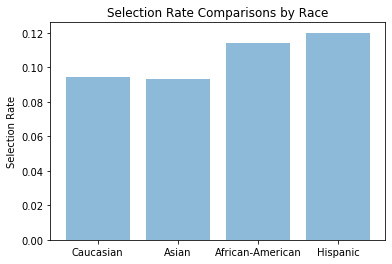

In [23]:
# FILL this Cell (1 Line) #
graphSelectionRates(selectedCandidates, candidates_processed, "race")
# FILL this Cell (1 Line) #

##### Questions:
 * Based on the last code block, report whether the model produces a disparate impact.
 * Based on your team's algorithm's design and result articulate what risk a disparate impact claim poses. 
 * If your algorithm's results do demonstrate a disparate impact in selection rates, from where in the algorithm's design or in the characteristics of the data have you found it to arise from? Is the bias materially traceable to some characteristic of the dataset? features you selected? You can use the tools in the subtasks to try and investigate skewed distributions, poor feature selection, etc. Report your findings.
 * Try tweaking the selection rate +/- 5, 10 percent, does your team notice any changes? If so, explain why this might be the case.
 
Great, now that we've covered the ranking model and have been exposed to basic disparate impact analysis, let's move 
to the final exercise of milestone 1!



